(parameters_recovery)=
# Parameters recovery, prior predictive and posterior predictive sampling

In [1]:
%%capture
import sys

import arviz as az
import jax.numpy as jnp
import matplotlib.pyplot as plt
import numpy as np
import pymc as pm
from numpy import loadtxt

from pyhgf import load_data
from pyhgf.distribution import HGFDistribution, hgf_logp

if 'google.colab' in sys.modules:
    ! pip install pyhgf

In [2]:
np.random.seed(123)

In this tutorial, we are going to demonstrate some forms of parameters recovery, prior predictive and posterior predictive sampling that can be a way to assess the strength of the model fitting.

## Continuous HGF
### Simulate a dataset

In [3]:
n_data = 6
dataset = []
for participant in range(n_data):
    input_data = []
    kappa_1 = 1.0
    omega_1 = -10.0
    omega_2 = -10.0
    mu_1 = 0.0
    mu_2 = 0.0
    pi_1 = 1e4
    pi_2 = 1e1
    
    # two-level hierarchical gaussian random walk
    for i in range(1000):
        
        # x2
        pi_2 = np.exp(omega_2)
        mu_2 = np.random.normal(mu_2, pi_2**.5)

        # x1
        pi_1 = np.exp(kappa_1 * mu_2 + omega_1)
        mu_1 = np.random.normal(mu_1, pi_1**.5)
        
        # input node
        u = np.random.normal(mu_1, 1e-4**.5)
        input_data.append(u)

    dataset.append(np.array(input_data))

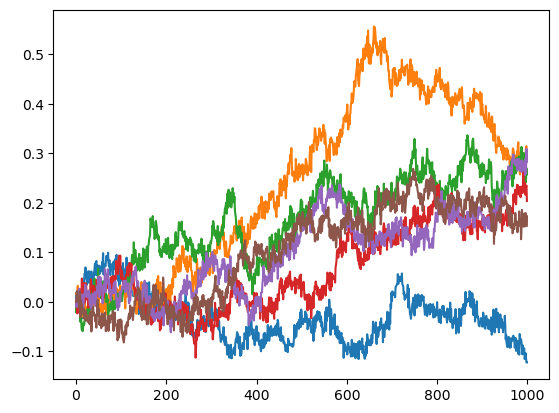

In [4]:
for rw in dataset:
    plt.plot(rw)

## Embedding a serie of HGFs in a graphical model

Here, we are goingin to estimate the parameter $omega_{1}$ from the time series created by the hierarchical random walks. All the time series were generated using $omega_{1} = -10.0$ and we want to see how the Bayesian inference can retrieve these values.

In [5]:
hgf_logp_op = HGFDistribution(
    n_levels=2,
    model_type="continuous",
    input_data=dataset,
)

In [6]:
with pm.Model() as model:
    
    # Priors
    # ------
    tonic_volatility_1 = pm.Normal("omega_1", mu=0.0, sigma=2.0, shape=n_data)

    # The multi-HGF distribution
    # --------------------------
    pm.Potential("hgf_loglike", hgf_logp_op(tonic_volatility_1=tonic_volatility_1, tonic_volatility_2=-10.0))

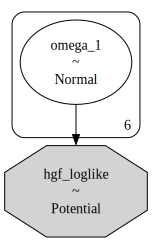

In [7]:
pm.model_to_graphviz(model)

In [8]:
with model:
    idata = pm.sample(chains=2)

No GPU/TPU found, falling back to CPU. (Set TF_CPP_MIN_LOG_LEVEL=0 and rerun for more info.)


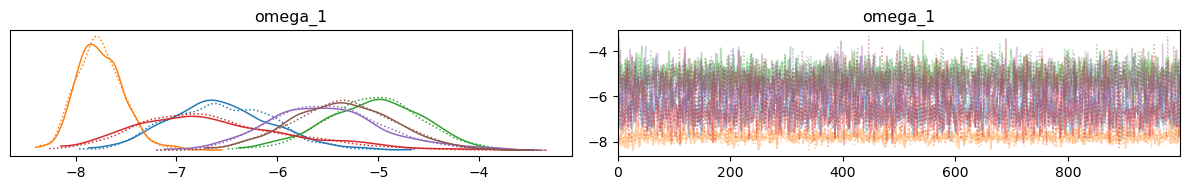

In [9]:
az.plot_trace(idata);
plt.tight_layout()

In [10]:
az.summary(idata)

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
omega_1[0],-6.552,0.528,-7.565,-5.610,0.012,0.008,2114.0,1356.0,1.0
omega_1[1],-7.756,0.235,-8.168,-7.330,0.006,0.004,1788.0,1043.0,1.0
omega_1[2],-5.048,0.475,-5.990,-4.185,0.009,0.006,2758.0,1515.0,1.0
omega_1[3],-6.595,0.789,-7.902,-5.092,0.019,0.014,2027.0,1164.0,1.0
omega_1[4],-5.516,0.568,-6.598,-4.447,0.012,0.009,2288.0,1286.0,1.0
omega_1[5],-5.346,0.521,-6.323,-4.394,0.012,0.008,2007.0,1413.0,1.0


# System configuration

In [11]:
%load_ext watermark
%watermark -n -u -v -iv -w -p pyhgf,jax,jaxlib

Last updated: Fri Nov 03 2023

Python implementation: CPython
Python version       : 3.9.16
IPython version      : 8.14.0

pyhgf : 0.0.9
jax   : 0.4.14
jaxlib: 0.4.14

sys       : 3.9.16 | packaged by conda-forge | (main, Feb  1 2023, 21:39:03) 
[GCC 11.3.0]
jax       : 0.4.14
arviz     : 0.16.1
numpy     : 1.22.0
matplotlib: 3.7.1
pymc      : 5.5.0

Watermark: 2.4.3

